# Assignment 3 - Image Segmentation using MRFs

## GrabCut

---
**TA** : Avinash, Samartha  
**Release date**: 21/03/22  
**Submission date** : 02/04/22

---

For this assignment you will implement the GrabCut method mentioned in this [paper](https://cvg.ethz.ch/teaching/cvl/2012/grabcut-siggraph04.pdf). It is essentially an iterative version of GraphCut as shown in the figure below. 
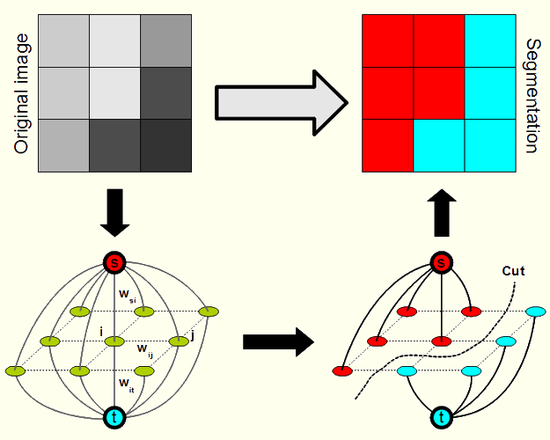

The code below takes an input image and follows these steps:
- It requires a bounding box to be drawn by the user to roughly segment out the foreground pixels
- It runs an initial min-cut optimization using the provided annotation
- The result of this optimization gives an initial segmentation 
- To further refine this segmentation, the user provides two kinds of strokes to aid the optimization
    - strokes on the background pixels
    - strokes on the foreground pixels
- The algorithm now utilizes this to refine the original segmentation

You are allowed to use standard GMM libraries for the implementation. For usage of other libraries, please contact the TAs.

You can view this [video](https://www.youtube.com/watch?v=aOqOwM-Qbtg) to get a better idea of the steps involved.

Image segmentation is one exciting application of MRFs. You can further read about other applications of MRFs for Computer Vision [here](https://cedar.buffalo.edu/~srihari/CSE574/Chap8/Ch8-PGM-Undirected/9.5-MRFinCV.pdf).

#### Useful Links
* https://courses.engr.illinois.edu/cs543/sp2011/lectures/Lecture%2012%20-%20MRFs%20and%20Graph%20Cut%20Segmentation%20-%20Vision_Spring2011.pdf

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn import mixture
from igraph import *

In [2]:
class EventHandler:
    """
    Class for handling user input during segmentation iterations 
    """
    def __init__(self, flags, img, _mask, colors):
        self.FLAGS = flags
        self.ix = -1
        self.iy = -1
        self.img = img
        self.img2 = self.img.copy()
        self._mask = _mask
        self.COLORS = colors

    @property
    def image(self):
        return self.img
    
    @image.setter
    def image(self, img):
        self.img = img
        
    @property
    def mask(self):
        return self._mask
    
    @mask.setter
    def mask(self, _mask):
        self._mask = _mask
    
    @property
    def flags(self):
        return self.FLAGS 
    
    @flags.setter
    def flags(self, flags):
        self.FLAGS = flags
    
    def handler(self, event, x, y, flags, param):

        # Draw the rectangle first
        if event == cv2.EVENT_LBUTTONDOWN:
            self.FLAGS['DRAW_RECT'] = True
            self.ix, self.iy = x,y

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_RECT'] == True:
                self.img = self.img2.copy()
                cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 2)
                self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
                self.FLAGS['rect_or_mask'] = 0

        elif event == cv2.EVENT_LBUTTONUP:
            self.FLAGS['DRAW_RECT'] = False
            self.FLAGS['rect_over'] = True
            cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 2)
            self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
            self.FLAGS['rect_or_mask'] = 0

        
        # Draw strokes for refinement 

        if event == cv2.EVENT_RBUTTONDOWN:
            if self.FLAGS['rect_over'] == False:
                print('Draw the rectangle first.')
            else:
                self.FLAGS['DRAW_STROKE'] = True
                cv2.circle(self.img, (x,y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x,y), 3, self.FLAGS['value']['val'], -1)

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_STROKE'] == True:
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x, y), 3, self.FLAGS['value']['val'], -1)

        elif event == cv2.EVENT_RBUTTONUP:
            if self.FLAGS['DRAW_STROKE'] == True:
                self.FLAGS['DRAW_STROKE'] = False
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x, y), 3, self.FLAGS['value']['val'], -1)

In [3]:
def run(filename: str):
    """
    Main loop that implements GrabCut. 
    
    Input
    -----
    filename (str) : Path to image
    """
    
    COLORS = {
    'BLACK' : [0,0,0],
    'RED'   : [0, 0, 255],
    'GREEN' : [0, 255, 0],
    'BLUE'  : [255, 0, 0],
    'WHITE' : [255,255,255]
    }

    DRAW_BG = {'color' : COLORS['BLACK'], 'val' : 0}
    DRAW_FG = {'color' : COLORS['WHITE'], 'val' : 1}

    FLAGS = {
        'RECT' : (0, 0, 1, 1),
        'DRAW_STROKE': False,         # flag for drawing strokes
        'DRAW_RECT' : False,          # flag for drawing rectangle
        'rect_over' : False,          # flag to check if rectangle is  drawn
        'rect_or_mask' : -1,          # flag for selecting rectangle or stroke mode
        'value' : DRAW_FG,            # drawing strokes initialized to mark foreground
    }

    img = cv2.imread(filename)
    img2 = img.copy()                                
    mask = np.zeros(img.shape[:2], dtype = np.uint8) # mask is a binary array with : 0 - background pixels
                                                     #                               1 - foreground pixels 
    output = np.zeros(img.shape, np.uint8)           # output image to be shown

    # Input and segmentation windows
    cv2.namedWindow('Input Image')
    cv2.namedWindow('Segmented output')
    
    EventObj = EventHandler(FLAGS, img, mask, COLORS)
    cv2.setMouseCallback('Input Image', EventObj.handler)
    cv2.moveWindow('Input Image', img.shape[1] + 10, 90)

    while(1):
        
        img = EventObj.image
        mask = EventObj.mask
        FLAGS = EventObj.flags
        cv2.imshow('Segmented output', output)
        cv2.imshow('Input Image', img)
        
        k = cv2.waitKey(1)

        # key bindings
        if k == 27:
            # esc to exit
            break
        
        elif k == ord('0'): 
            # Strokes for background
            FLAGS['value'] = DRAW_BG
        
        elif k == ord('1'):
            # FG drawing
            FLAGS['value'] = DRAW_FG
        
        elif k == ord('r'):
            # reset everything
            FLAGS['RECT'] = (0, 0, 1, 1)
            FLAGS['DRAW_STROKE'] = False
            FLAGS['DRAW_RECT'] = False
            FLAGS['rect_or_mask'] = -1
            FLAGS['rect_over'] = False
            FLAGS['value'] = DRAW_FG
            img = img2.copy()
            mask = np.zeros(img.shape[:2], dtype = np.uint8) 
            EventObj.image = img
            EventObj.mask = mask
            output = np.zeros(img.shape, np.uint8)
        
        elif k == 13: 
            # Press carriage return to initiate segmentation
            
            #-------------------------------------------------#
            # Implement GrabCut here.                         #  
            # Function should return a mask which can be used #
            # to segment the original image as shown on L90   # 
            #-------------------------------------------------#
            rect = FLAGS['RECT']
            roi = [rect[0],rect[1],rect[0]+rect[2],rect[1]+rect[3]]
            
            print(roi)

            EventObj.flags = FLAGS
            mask2 = np.where((mask == 1), 255, 0).astype('uint8')
            output = cv2.bitwise_and(img2, img2, mask = mask2)

    return 

In [4]:
# defining some of the global parameters
gamma = 50
# num of iterations
num_of_itr = 5
# number of components
num_of_components = 5

In [5]:
def initialize_alpha(roi,img):
    h, w, c = img.shape
    alpha = np.zeros((h,w))

    for i in range(h):
        for j in range(w):
            if i>=roi[1] and i<=roi[3] and j>=roi[0] and j<=roi[2]:
                alpha[i,j] = 1
            else:
                alpha[i,j] = 0

    return alpha


def weights_from_gmm(alpha,img):
    fg_pixels = []
    bg_pixels = []
    all_pixels = []
    h, w, c = img.shape
    for i in range(h):
        for j in range(w):
            if alpha[i,j] == 0:
                bg_pixels.append(img[i,j])
            else:
                fg_pixels.append(img[i,j])
                
            all_pixels.append(img[i,j])

    fg_gmm = mixture.GaussianMixture(covariance_type='full').fit(fg_pixels)
    bg_gmm = mixture.GaussianMixture(covariance_type='full').fit(bg_pixels)
    fg_weights = -fg_gmm.score_samples(all_pixels)
    bg_weights = -bg_gmm.score_samples(all_pixels)
    return fg_weights, bg_weights


def calc_beta(img):
    h, w, c = img.shape
    cnt = 0
    beta = 0.0
    x = [-1,0,0,1]
    y = [0,-1,1,0]
    for i in range(h):
        for j in range(w):
            for k in range(4):
                if i+x[k]>=0 and i+x[k]<h and j+y[k]>=0 and j+y[k]<w:
                    beta += (img[i+x[k],j+y[k]] - img[i,j])**2
                    cnt += 1
    # for each edge we have done the square buisness twice, so dividing it by 2 here, but also by the formula we need to multiply by 2 and then take inverse. 
    # So, no need to divide by two
    beta = cnt/beta
    return beta


def binary_weight(px1,px2,beta):
    weight = gamma * np.exp(-1.0 * beta * np.sum((px1-px2)**2))
    return weight


def graph_creation(alpha, fg_weights, bg_weights, img):
    h, w, c = img.shape
    beta = calc_beta(img)

    g = Graph()
    # assume 0 as src and h*w+1 as sink vertices    
    g.add_vertices(h*w+2)
    src = 0
    sink = h*w+1
    weights = []
    edges = []
    cnt = 0
        
    for i in range(h):
        for j in range(w):
            # For each (i,j) to find vertex number u do: i*w + j + 1             
            if alpha[i,j] == 1:
                vertex = i*w+j+1
                edges.append((src,vertex))
                weights.append(fg_weights[cnt])

                edges.append((sink,vertex))
                weights.append(bg_weights[cnt])

            if i+1<h and alpha[i,j]!=alpha[i+1,j]:
                vertex1 = (i+1)*w+j+1
                vertex2 = i*w+j+1
                edges.append((vertex1,vertex2))
                weights.append(binary_weight(img[i+1][j], img[i][j], beta))

            if j+1<w and alpha[i,j]!=alpha[i,j+1]:
                vertex1 = i*w+j+1+1
                vertex2 = i*w+j+1
                edges.append((vertex1,vertex2))
                weights.append(binary_weight(img[i][j+1], img[i][j], beta))
                
            cnt += 1
    
    g.add_edges(edges)
    g.es['weights'] = weights
    maxflow = g.maxflow(src,sink,capacity='weights')
    par = maxflow.partition
    return par[1]
    


def grabcut(roi,img):
    h,w,c = img.shape
    alpha = initialize_alpha(roi,img)

    for it in range(num_of_itr):
        print('Iteration: ',it+1)

        fg_weights, bg_weights  = weights_from_gmm(alpha,img)
        foreground = graph_creation(alpha, fg_weights, bg_weights, img)

        alpha = np.zeros((h,w))
        roi_img = np.zeros(img.shape)
        for i in range(h):
            for j in range(w):
                vertex = i*w+j+1
                if vertex in foreground:
                    alpha[i][j] = 1
                    roi_img[i][j] = img[i][j]                    

        roi_img = roi_img.astype(np.uint8)
        img = roi_img
    return img

In [16]:
def convert_to_BW(img):
    h,w,c = img.shape
    for i in range(h):
        for j in range(w):
            if img[i,j,0] != 0 or img[i,j,1] != 0 or img[i,j,2] != 0:
                img[i,j,0] = 255
                img[i,j,1] = 255
                img[i,j,2] = 255

    img = np.uint8(img)
    return img


def metrics(predicted,ground):
    h,w,c = predicted.shape
    
    # accuracy
    cnt = 0
    for i in range(h):
        for j in range(w):
            if (predicted[i,j,0] == ground[i,j,0]):
                cnt += 1

    accuracy = cnt/(h*w)
    print('Accuracy: ',accuracy)

    # jaccard similarity
    union = 0
    intersection = 0
    for i in range(h):
        for j in range(w):
            if predicted[i,j,0] != 0 and ground[i,j,0] != 0:
                intersection += 1

            if predicted[i,j,0] != 0 or ground[i,j,0] != 0:
                union += 1

    jc = intersection/union
    print('Jaccard Similarity: ',jc)

    # dice similarity -> h*w is area of one image and both images have same size that's why 2*h*w
    dice_similarity = (2*intersection)/(2*h*w)
    print('Dice Similarity: ',dice_similarity)
    

def show_outputs(name,input_image_path, ground_truth_path,roi):
    fig = plt.figure(figsize=(20, 7))
    rows = 1
    columns = 3

    img = cv2.imread(input_image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
    h,w,c = img.shape

    # fig.add_subplot(rows, columns, 1)
    # plt.imshow(img)
    # plt.title('Original Image')
    # plt.axis('off')

    temp_img = img.copy()
    op = grabcut(roi,temp_img)
    op = cv2.resize(op,(w,h))

    # fig.add_subplot(rows, columns, 2)
    # plt.imshow(op)
    cv2.imwrite(name,op)
    # plt.title('RGB Segmented Image')
    # plt.axis('off')

    segmented_image = convert_to_BW(op)

    # fig.add_subplot(rows, columns, 3)
    # plt.imshow(segmented_image)
    # plt.title('Black & White Segmented Image')
    # plt.axis('off')
    # plt.show()

    ground = cv2.imread(ground_truth_path)
    # cv2.resize(ground, (w,h))
    metrics(segmented_image, ground)

In [7]:
# IMG1
show_outputs('../images/banana1.jpg', '../ground_truth/banana1.bmp')

TypeError: show_outputs() missing 2 required positional arguments: 'ground_truth_path' and 'roi'

Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5


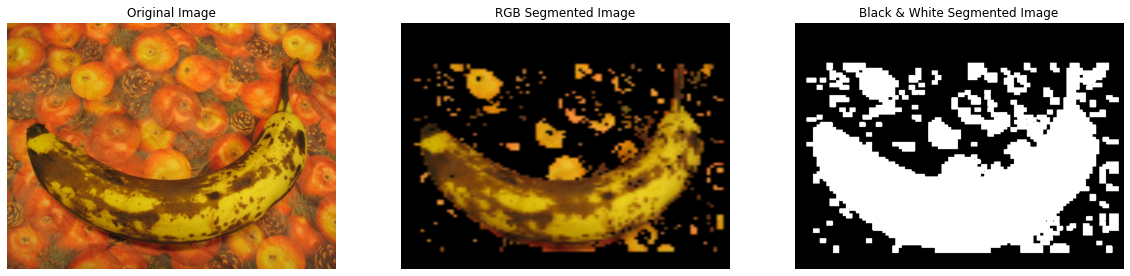

Accuracy:  0.811337890625
Jaccard Similarity:  0.5549301182614038
Dice Similarity:  0.23523111979166667


In [ ]:
# IMG2
show_outputs('../images/banana2.jpg', '../ground_truth/banana2.bmp', [5, 18, 96, 91])

Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5


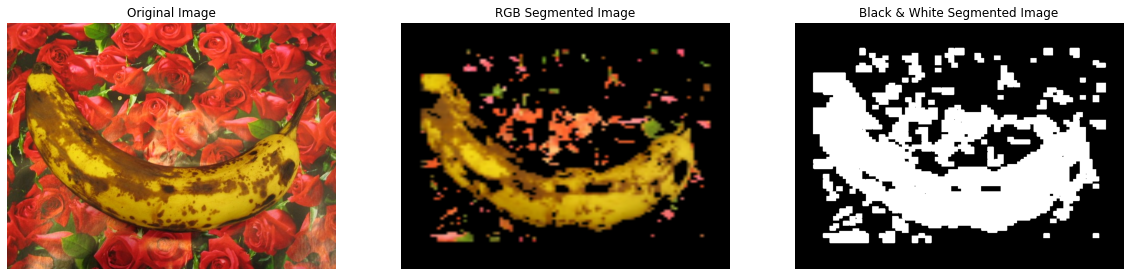

Accuracy:  0.8299772135416666
Jaccard Similarity:  0.5606631563009943
Dice Similarity:  0.21697591145833334


In [8]:
# IMG3
show_outputs('../images/banana3.jpg', '../ground_truth/banana3.bmp', [7, 12, 92, 87])

Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5


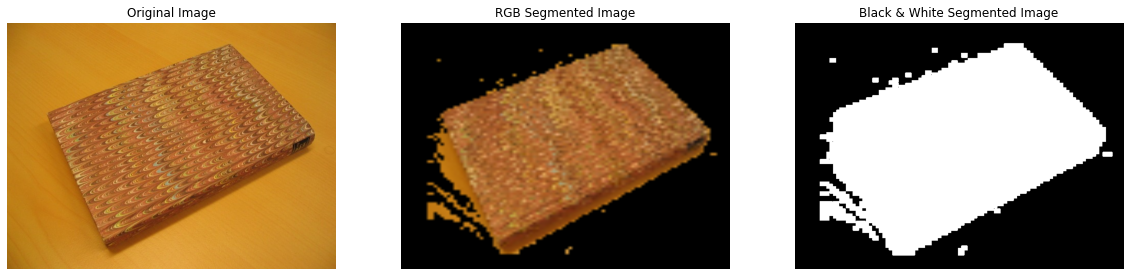

Accuracy:  0.91259765625
Jaccard Similarity:  0.8088056226100703
Dice Similarity:  0.369736328125


In [ ]:
# IMG4
show_outputs('../images/book.jpg', '../ground_truth/book.bmp', [9, 10, 94, 92])

Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5


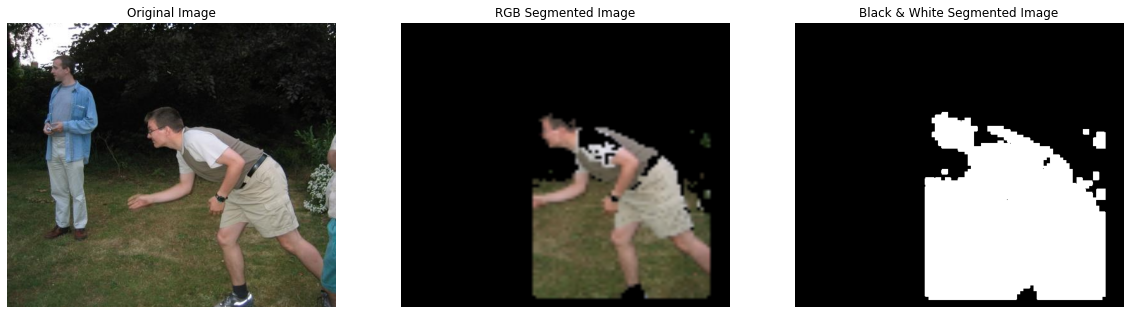

Accuracy:  0.821017094017094
Jaccard Similarity:  0.4012152405461434
Dice Similarity:  0.11992735042735042


In [ ]:
# IMG5
show_outputs('../images/bool.jpg', '../ground_truth/bool.bmp', [41, 30, 92, 95])

In [17]:
# IMG6
show_outputs("./bush.jpg",'./images/bush.jpg', './ground_truth/bush.bmp', [23, 10, 77, 94])

Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Accuracy:  0.8160481481481482
Jaccard Similarity:  0.0
Dice Similarity:  0.0


<Figure size 1440x504 with 0 Axes>

Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5


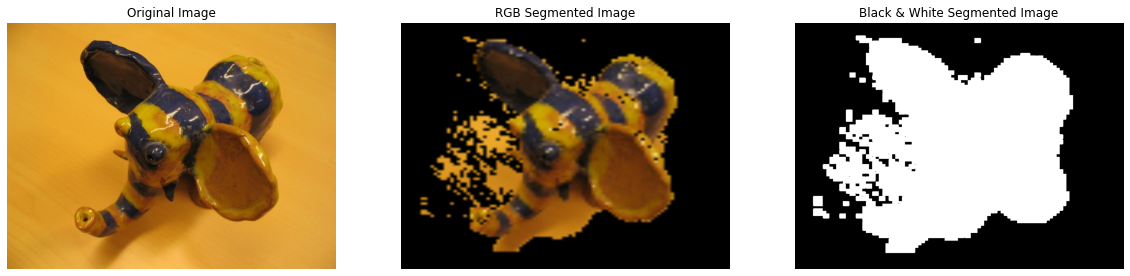

Accuracy:  0.861689453125
Jaccard Similarity:  0.6877025864920289
Dice Similarity:  0.3045703125


In [9]:
# IMG7
show_outputs('../images/ceramic.jpg', '../ground_truth/ceramic.bmp', [7, 5, 91, 91])

Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5


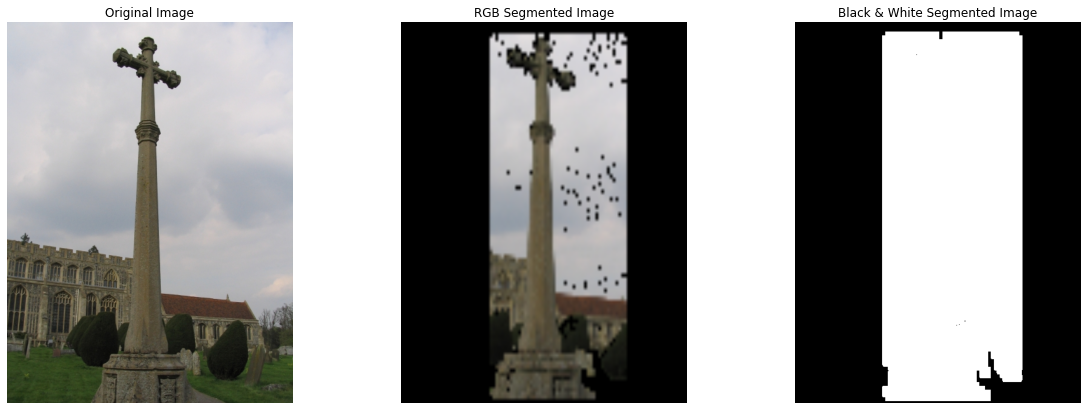

Accuracy:  0.5500333333333334
Jaccard Similarity:  0.3001630193722314
Dice Similarity:  0.1929925925925926


In [10]:
# IMG8
show_outputs('../images/cross.jpg', '../ground_truth/cross.bmp', [32, 4, 77, 97])

Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5


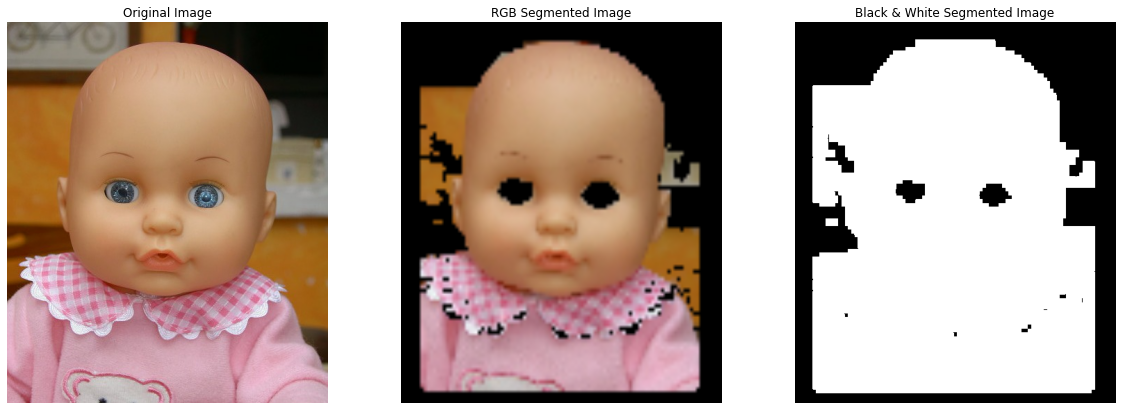

Accuracy:  0.6400184514938614
Jaccard Similarity:  0.4957948389448166
Dice Similarity:  0.35397692774741957


In [11]:
# IMG9
show_outputs('../images/doll.jpg', '../ground_truth/doll.bmp', [7, 6, 91, 95])

Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5


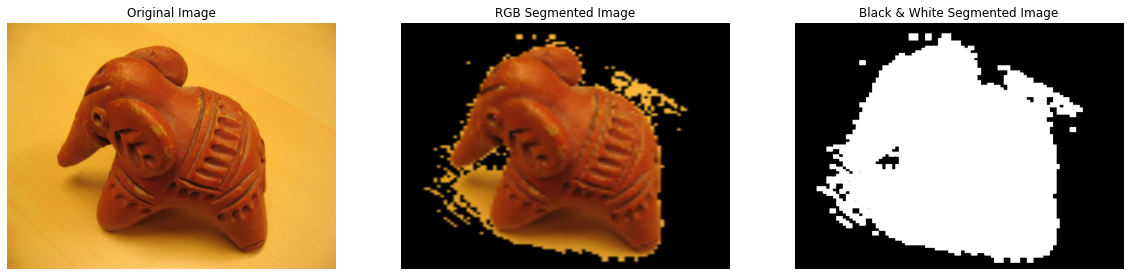

Accuracy:  0.8494921875
Jaccard Similarity:  0.6810298439504946
Dice Similarity:  0.32134765625


In [12]:
# IMG10
show_outputs('../images/elefant.jpg', '../ground_truth/elefant.bmp', [8, 6, 88, 95])

In [18]:
# IMG11
show_outputs("flower.jpg",'./images/flower.jpg', './ground_truth/flower.bmp', [18, 13, 80, 88])

Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Accuracy:  0.7885074074074074
Jaccard Similarity:  0.0
Dice Similarity:  0.0


<Figure size 1440x504 with 0 Axes>

Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5


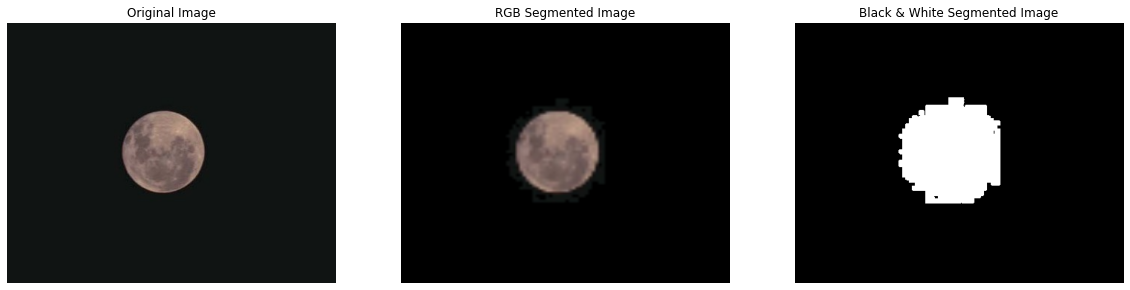

Accuracy:  0.9593794440853265
Jaccard Similarity:  0.5974891109403023
Dice Similarity:  0.06029734970911441


In [38]:
# IMG12
show_outputs('../images/fullmoon.jpg', '../ground_truth/fullmoon.bmp', [26, 25, 66, 71])

In [19]:
# IMG13
show_outputs("grave.jpg",'./images/grave.jpg', './ground_truth/grave.bmp', [41, 25, 76, 74])

Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Accuracy:  0.8731925925925926
Jaccard Similarity:  0.0
Dice Similarity:  0.0


<Figure size 1440x504 with 0 Axes>

Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5


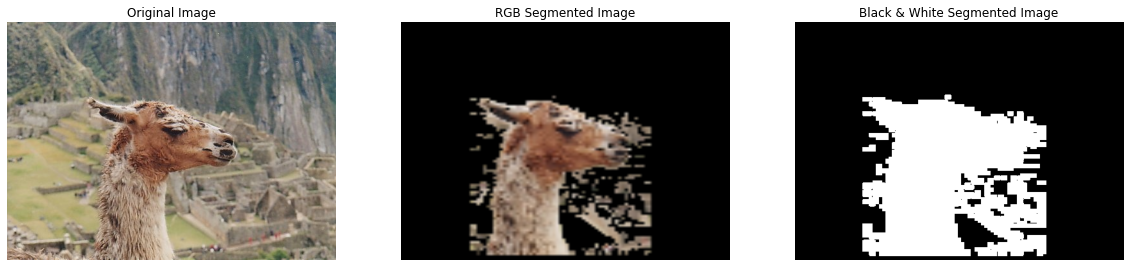

Accuracy:  0.8818429722104002
Jaccard Similarity:  0.5920840211141142
Dice Similarity:  0.17150318143366802


In [16]:
# IMG14
show_outputs('../images/llama.jpg', '../ground_truth/llama.bmp', [22, 27, 74, 96])

Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5


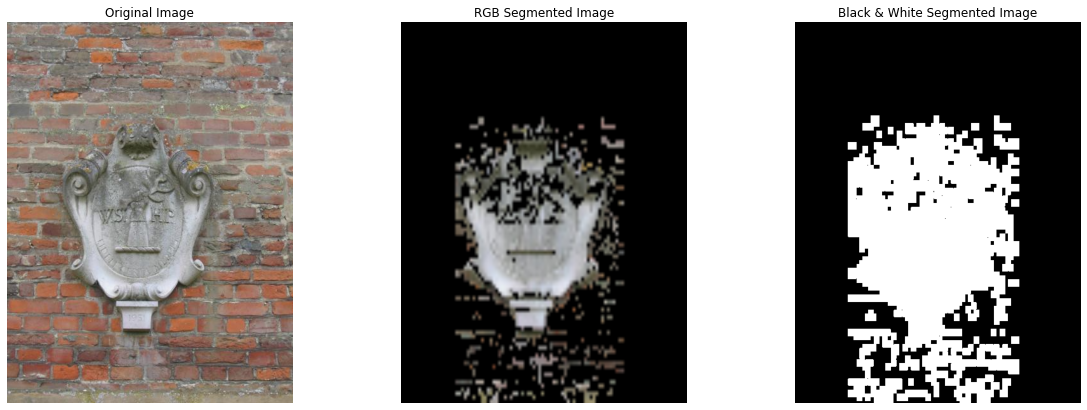

Accuracy:  0.8558740740740741
Jaccard Similarity:  0.5538613225717692
Dice Similarity:  0.17892592592592593


In [17]:
# IMG15
show_outputs('../images/memorial.jpg', '../ground_truth/memorial.bmp', [20, 26, 76, 99])

Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5


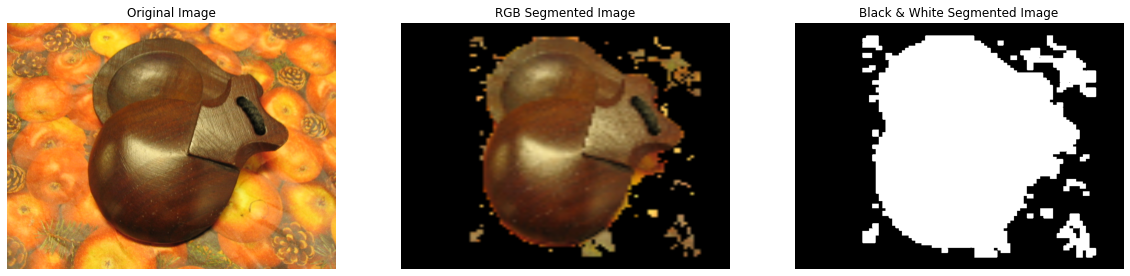

Accuracy:  0.9049837239583334
Jaccard Similarity:  0.7854065578591384
Dice Similarity:  0.34775716145833335


In [18]:
# IMG16
show_outputs('../images/music.jpg', '../ground_truth/music.bmp', [22, 7, 89, 93])

Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5


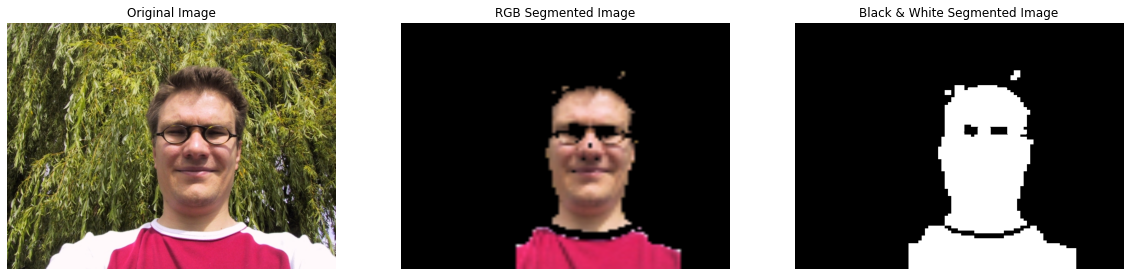

Accuracy:  0.9144037037037037
Jaccard Similarity:  0.7012886298129742
Dice Similarity:  0.20095555555555555


In [34]:
# IMG17
show_outputs('../images/person1.jpg', '../ground_truth/person1.bmp', [36, 21, 83, 99])

Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5


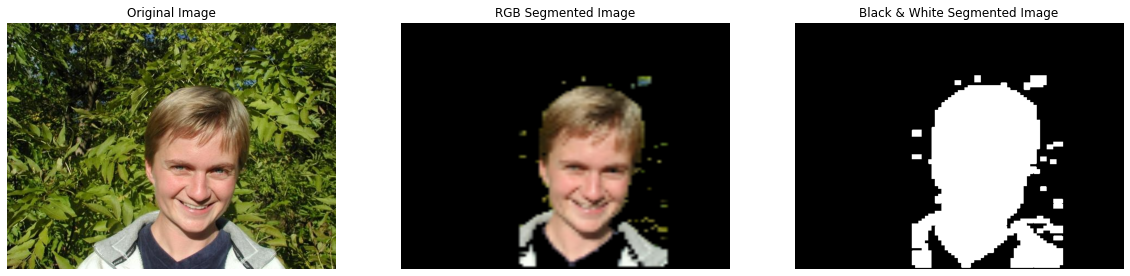

Accuracy:  0.9325407407407408
Jaccard Similarity:  0.7067319303782182
Dice Similarity:  0.16256666666666666


In [40]:
# IMG18
show_outputs('../images/person2.jpg', '../ground_truth/person2.bmp', [37, 23, 79, 97])

Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5


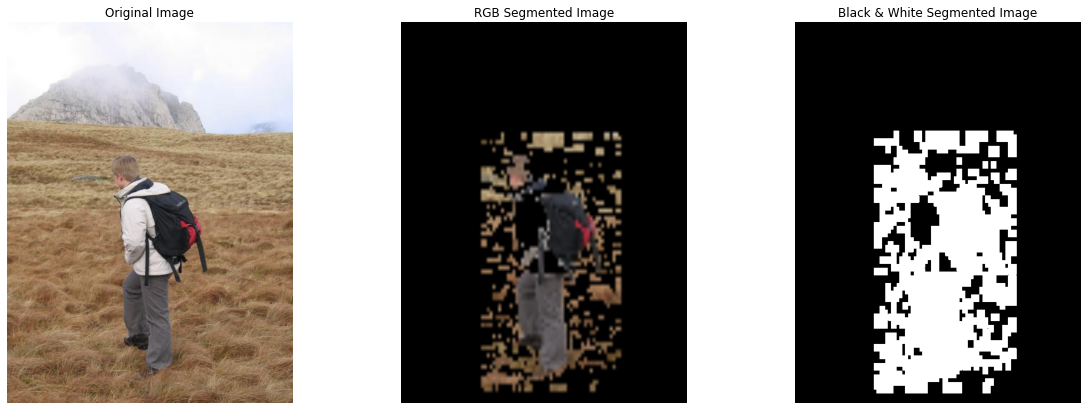

Accuracy:  0.8247814814814814
Jaccard Similarity:  0.31983322550499604
Dice Similarity:  0.08239259259259259


In [22]:
# IMG19
show_outputs('../images/person3.jpg', '../ground_truth/person3.bmp', [29, 30, 75, 95])

Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5


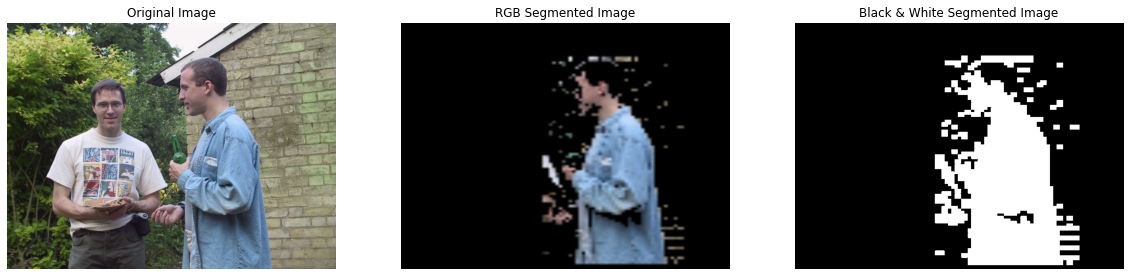

Accuracy:  0.9305
Jaccard Similarity:  0.6985493742871371
Dice Similarity:  0.16105185185185186


In [36]:
# IMG20
show_outputs('../images/person4.jpg', '../ground_truth/person4.bmp', [44, 15, 84, 96])

Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5


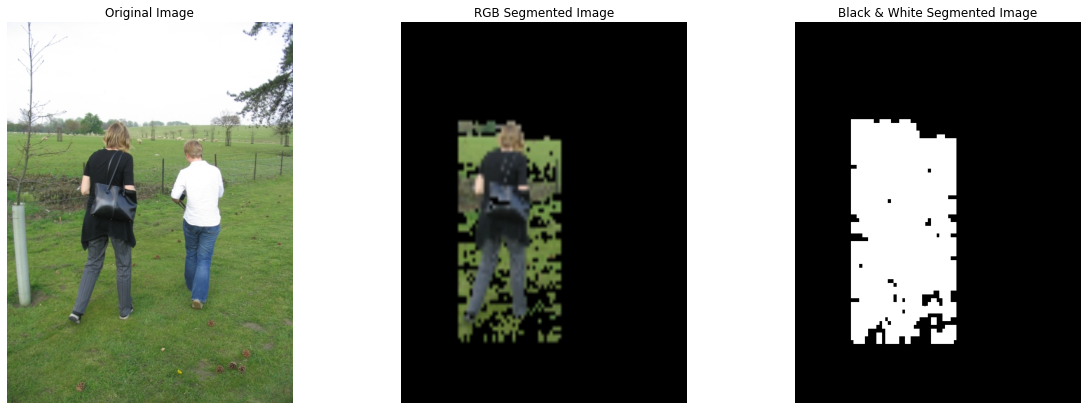

Accuracy:  0.8728333333333333
Jaccard Similarity:  0.34665956272715165
Dice Similarity:  0.06747407407407408


In [24]:
# IMG21
show_outputs('../images/person5.jpg', '../ground_truth/person5.bmp', [21, 24, 54, 82])

Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5


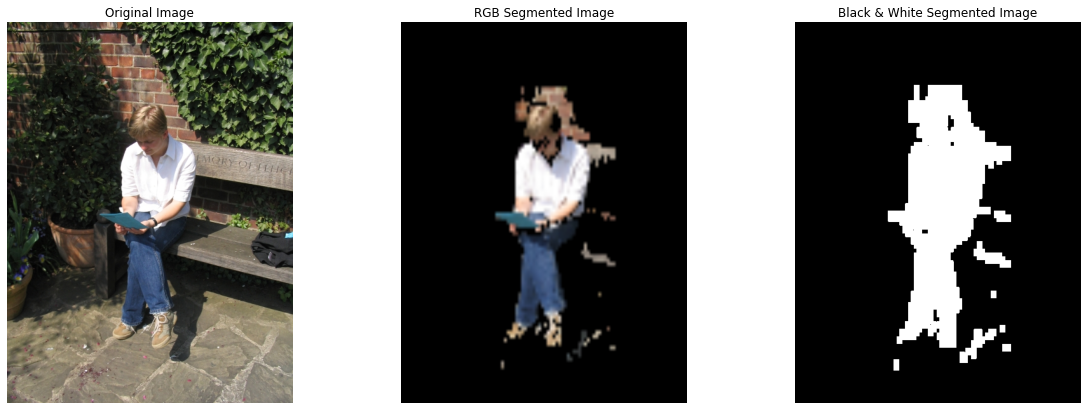

Accuracy:  0.9458111111111112
Jaccard Similarity:  0.6604706209969368
Dice Similarity:  0.10541111111111111


In [25]:
# IMG22
show_outputs('../images/person6.jpg', '../ground_truth/person6.bmp', [34, 18, 73, 89])

Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5


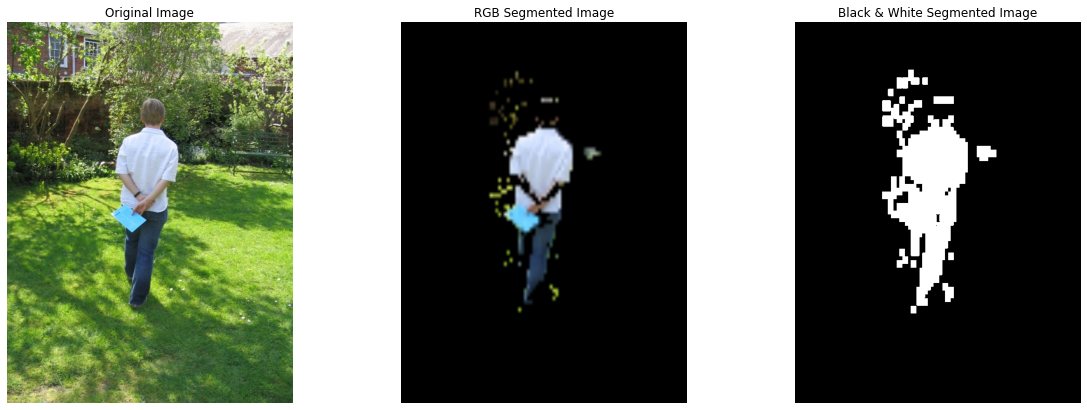

Accuracy:  0.9615148148148148
Jaccard Similarity:  0.6102400600150037
Dice Similarity:  0.060255555555555555


In [26]:
# IMG23
show_outputs('../images/person7.jpg', '../ground_truth/person7.bmp', [32, 14, 68, 80])

Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5


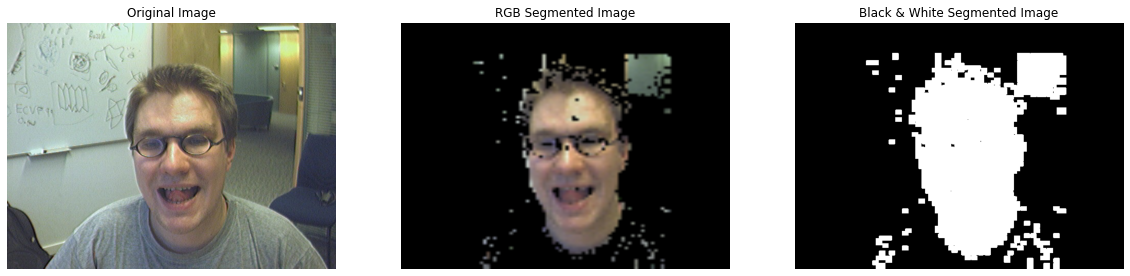

Accuracy:  0.921796875
Jaccard Similarity:  0.7063331988705123
Dice Similarity:  0.188095703125


In [41]:
# IMG24
show_outputs('../images/person8.jpg', '../ground_truth/person8.bmp', [21, 14, 80, 98])

Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5


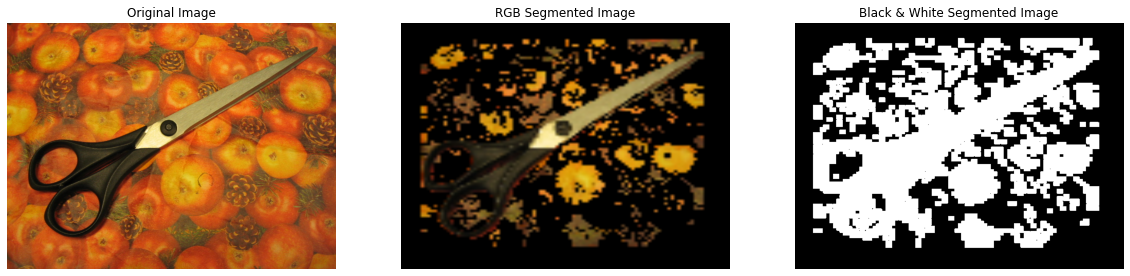

Accuracy:  0.6633365885416667
Jaccard Similarity:  0.24335337927805334
Dice Similarity:  0.10827799479166667


In [28]:
# IMG25
show_outputs('../images/scissors.jpg', '../ground_truth/scissors.bmp', [7, 8, 90, 89])

Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5


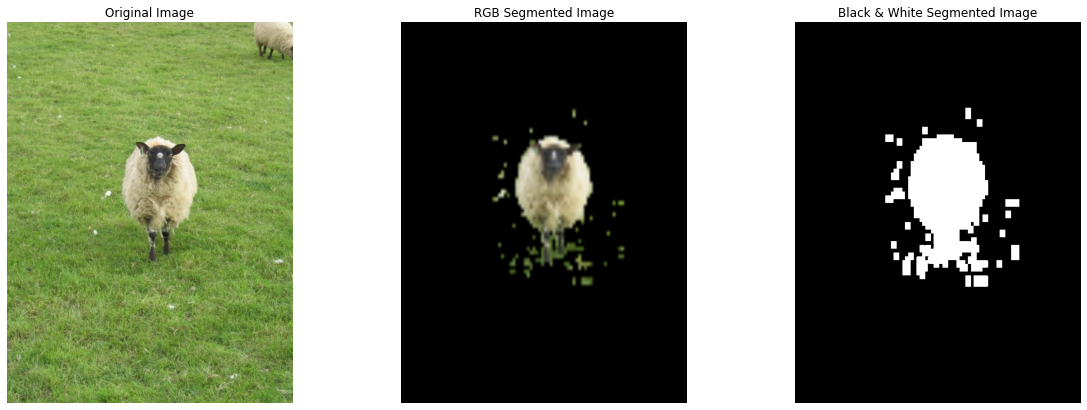

Accuracy:  0.9627703703703704
Jaccard Similarity:  0.5826101399327326
Dice Similarity:  0.05196666666666667


In [29]:
# IMG26
show_outputs('../images/sheep.jpg', '../ground_truth/sheep.bmp', [33, 24, 76, 67])

Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5


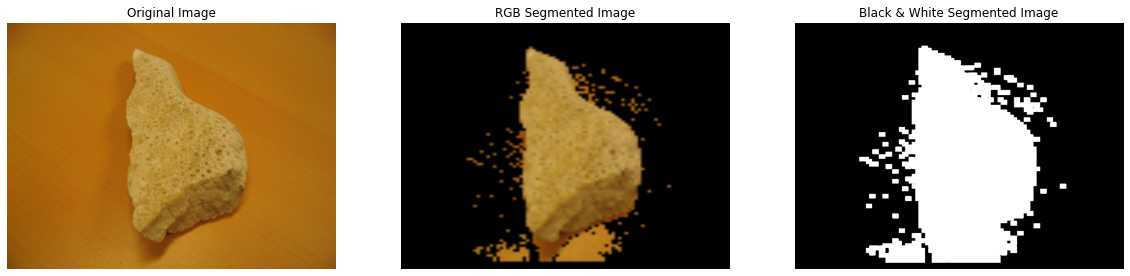

Accuracy:  0.9020865885416667
Jaccard Similarity:  0.6601665329733027
Dice Similarity:  0.19020833333333334


In [30]:
# IMG27
show_outputs('../images/stone1.jpg', '../ground_truth/stone1.bmp', [21, 7, 84, 95])

Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5


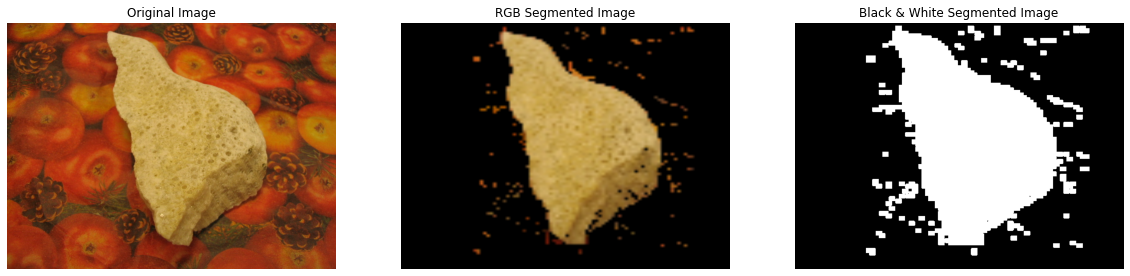

Accuracy:  0.9333821614583333
Jaccard Similarity:  0.7843610385231392
Dice Similarity:  0.242314453125


In [31]:
# IMG28
show_outputs('../images/stone2.jpg', '../ground_truth/stone2.bmp', [23, 3, 87, 92])

Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5


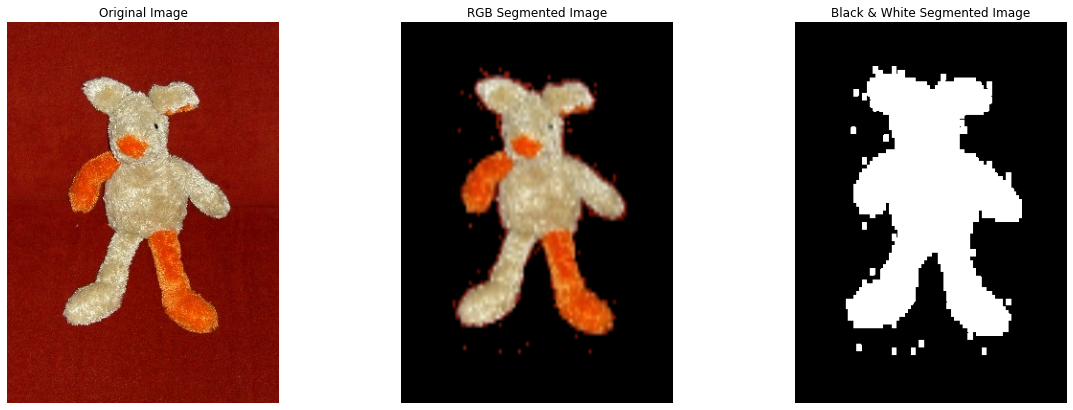

Accuracy:  0.9482358977988534
Jaccard Similarity:  0.8050576397681082
Dice Similarity:  0.21377132139571095


In [32]:
# IMG29
show_outputs('../images/teddy.jpg', '../ground_truth/teddy.bmp', [18, 10, 83, 87])

Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5


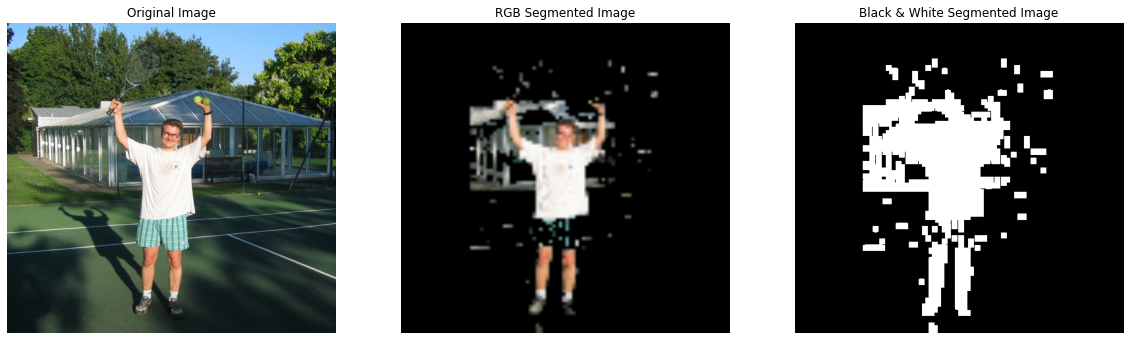

Accuracy:  0.8950762711864407
Jaccard Similarity:  0.41852765058119057
Dice Similarity:  0.07552118644067797


In [33]:
# IMG30
show_outputs('../images/tennis.jpg', '../ground_truth/tennis.bmp', [22, 13, 76, 98])